In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import *
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam

import os
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report


In [2]:
#configuring gpu memory usage

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Set a memory limit for the first GPU (assuming at least one GPU is available)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])  # Limit to 4GB
        
        # After setting the configuration, list logical GPUs to verify the configuration
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        
        # Print information about the available GPUs and logical GPUs
        print(len(gpus), "Physical GPU(s) available,", len(logical_gpus), "Logical GPU(s) configured.")
        
    except RuntimeError as e:
        # Print any runtime error that occurs during configuration
        print("Error:", e)
else:
    print("No GPU(s) available. TensorFlow cannot use GPU acceleration.")


1 Physical GPU(s) available, 1 Logical GPU(s) configured.


In [3]:
# helper function for plotting model history
def plot_training_history(history):
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Reading and preparing data for model training, Using ImageDataGenrator from tensorflow to use image augmentations for training. 

In [4]:
df = pd.read_csv("../balanced_data.csv")
df['cancer'] = df['cancer'].astype(str)


cropped_image_names = []
for im in os.listdir('../CroppedDataset2'):
    cropped_image_names.append(im)

df['cropped_image_path'] = cropped_image_names

In [5]:
train_df, val_df = train_test_split(df, test_size=0.08, random_state=101)


In [6]:
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 16
NUM_EPOCHS = 50
LEARNING_RATE = 0.0001
INPUT_FOLDER = '../CroppedDataset2'

In [7]:
#setting up the training and validation datagenerator objects.

train_datagen = ImageDataGenerator(
    rescale=1./255,             
    rotation_range=20,          
    width_shift_range=0.2,      
    height_shift_range=0.2,     
    shear_range=0.2,            
    zoom_range=0.2,             
    horizontal_flip=True,
    brightness_range=(0.5, 1.5)    
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=INPUT_FOLDER,                 
    x_col='cropped_image_path',                      
    y_col='cancer',                       
    target_size=IMAGE_SIZE,                
    batch_size=16,
    class_mode='binary'                   
)


val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=INPUT_FOLDER,
    x_col='cropped_image_path',
    y_col='cancer',
    target_size=IMAGE_SIZE,
    batch_size=16,
    class_mode='binary'
)

Found 2130 validated image filenames belonging to 2 classes.
Found 186 validated image filenames belonging to 2 classes.


## Model training and evalutation metrics.

In [10]:
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))


model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))


model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))


model.add(Flatten())

model.add(Dense(256, activation='relu',))
model.add(Dropout(0.2)) 

model.add(Dense(1,activation='sigmoid'))

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt,loss=['binary_crossentropy'],metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 64)      

In [12]:
model_history = model.fit(train_generator,epochs=50,validation_data=val_generator,steps_per_epoch=50)

Epoch 1/50
50/50 [==============================] - 11s 147ms/step - loss: 0.6936 - accuracy: 0.4885 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/50
50/50 [==============================] - 7s 144ms/step - loss: 0.6939 - accuracy: 0.4900 - val_loss: 0.6932 - val_accuracy: 0.5054
Epoch 3/50
50/50 [==============================] - 7s 141ms/step - loss: 0.6929 - accuracy: 0.5013 - val_loss: 0.6940 - val_accuracy: 0.4946
Epoch 4/50
50/50 [==============================] - 7s 141ms/step - loss: 0.6941 - accuracy: 0.4888 - val_loss: 0.6932 - val_accuracy: 0.5054
Epoch 5/50
50/50 [==============================] - 7s 140ms/step - loss: 0.6937 - accuracy: 0.4720 - val_loss: 0.6933 - val_accuracy: 0.4946
Epoch 6/50
50/50 [==============================] - 7s 142ms/step - loss: 0.6933 - accuracy: 0.4988 - val_loss: 0.6935 - val_accuracy: 0.4946
Epoch 7/50
50/50 [==============================] - 7s 140ms/step - loss: 0.6934 - accuracy: 0.4975 - val_loss: 0.6934 - val_accuracy: 0.4946
Epoch

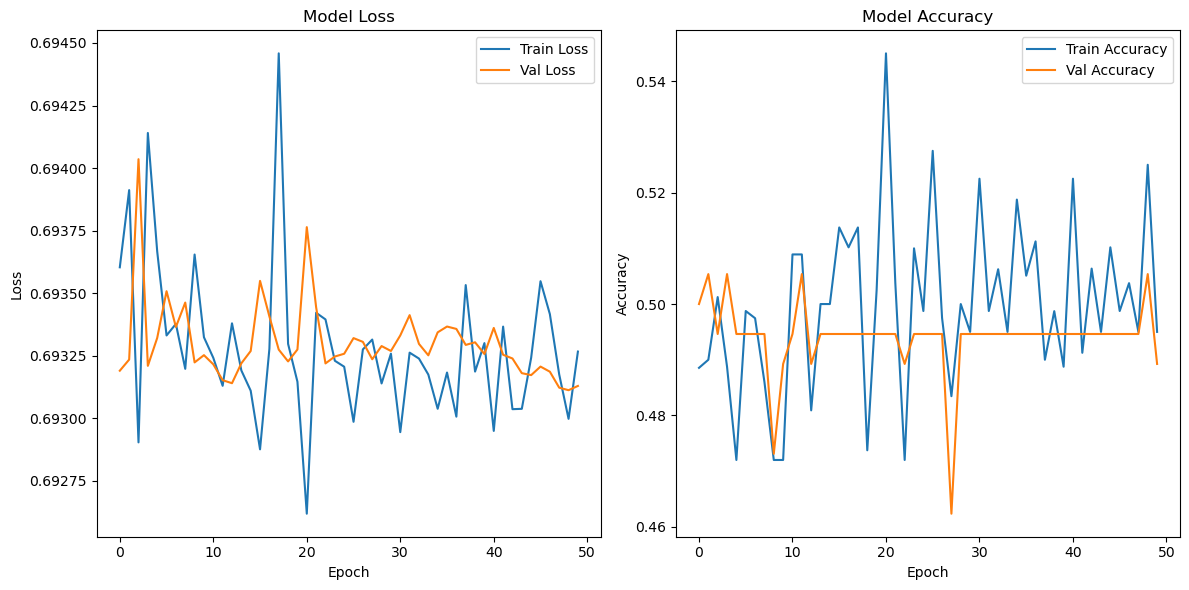

In [13]:
plot_training_history(model_history)

In [14]:
preds_a = (model.predict(val_generator) > 0.5).astype("int32")
y_true = val_generator.classes

12/12 [==============================] - 1s 41ms/step


In [16]:
val_loss, val_accuracy = model.evaluate(val_generator, steps=len(val_generator))

12/12 [==============================] - 1s 34ms/step - loss: 0.6931 - accuracy: 0.4892


In [17]:
class_names = val_generator.class_indices.keys()
report = classification_report(y_true, preds_a, target_names=class_names)

In [18]:
print(report)

              precision    recall  f1-score   support

           0       0.50      0.70      0.58        94
           1       0.47      0.27      0.34        92

    accuracy                           0.49       186
   macro avg       0.48      0.49      0.46       186
weighted avg       0.48      0.49      0.46       186

